In [1]:
!git clone https://github.com/johacks/RedesNeuronales.git

Cloning into 'RedesNeuronales'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 34 (delta 3), reused 29 (delta 3), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [ ]:
import os

# Tensorflow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as krl
from tensorflow.keras import models as krm

#Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Google file system
# from google.colab import drive
# drive.mount('/gdrive', force_remount=True)

## Recoger los datos de entrenamiento, validación y test

In [ ]:
BASE_DIR = './data'
ATT_FILE = f'{BASE_DIR}/FootballPlayerPreparedCleanAttributes.csv'
LABEL_FILE = f'{BASE_DIR}/FootballPlayerOneHotEncodedClasses.csv'

TRAIN_RATE = 0.8
VAL_RATE = 0.1
TEST_RATE = 0.1

attributes = pd.read_csv(ATT_FILE)
label = pd.read_csv(LABEL_FILE)

n_instances = attributes.shape[0]
n_train = int(n_instances*TRAIN_RATE)
n_val = int(n_instances*VAL_RATE)
n_test = n_instances - (n_train + n_val)

x_train = attributes.values[:n_train]
y_train = label.values[:n_train]

x_val = attributes.values[n_train:n_train+n_val]
y_val = label.values[n_train:n_train+n_val]

x_test = attributes.values[n_train+n_val:]
y_test = label.values[n_train+n_val:]

print ('x_train:', x_train.shape)
print ('y_train:', y_train.shape)

print ('x_val:', x_val.shape)
print ('y_val:', y_val.shape)

print ('x_test:', x_test.shape)
print ('y_test:', y_test.shape)

print(f'checksum: {x_train.shape[0]+x_val.shape[0]+x_test.shape[0]}={n_instances}')

x_train: (12897, 17)
y_train: (12897, 4)
x_val: (1612, 17)
y_val: (1612, 4)
x_test: (1613, 17)
y_test: (1613, 4)
checksum: 16122=16122


## Diseñar el workflow para la prueba de modelos

In [ ]:
INPUTS = x_train.shape[1]
OUTPUTS = y_train.shape[1]
import sys

class Experiment:
    # Accuracy must be first
    default_metrics = ['categorical_accuracy', 'AUC']

    default_label_name_association = {
        'categorical_accuracy': 'Accuracy',
        'auc': 'Area under ROC curve',
        'loss': 'Categorical cross-entropy (loss)'
    }

    def __init__(self, e_id, model=None, optimizer='SGD', epochs=500, metrics=None,
                 loss='categorical_crossentropy', label_name_association=None, verbose=1, human_error=0.0, path='./models'):
        self.e_id = e_id
        self.metrics = self.default_metrics if not metrics else metrics
        self.label_name_association = self.default_label_name_association if not label_name_association else label_name_association
        self.epochs = epochs
        self.model = model
        self.verbose = verbose
        self.human_error = human_error
        if model:
            self.model.add(krl.Dense(units=OUTPUTS, activation='softmax'))
            self.model.compile(
                optimizer=optimizer,
                loss=loss,
                metrics=self.metrics
            )
        self.path = f'{path}/m_{self.e_id}'

    def run(self):
        history = self.model.fit(x_train, y_train, epochs=self.epochs, verbose=self.verbose, validation_data=(x_val, y_val))
        self.model.summary()
        self.plot_history(history)
        self.print_metrics()
        self.save()


    def plot_history(self, history):
        fig = plt.figure(figsize=(22, 10), constrained_layout=True)
        rows = 2
        cols = int(np.ceil(len(history.history) / (2 * rows)))
        gs = fig.add_gridspec(rows, cols)
        fig.suptitle('Resultados')

        for i, key in enumerate(self.label_name_association.keys()):
            label = self.label_name_association[key]
            r, c = i // cols, i % cols
            f_ax = fig.add_subplot(gs[r, c])
            f_ax.plot(history.history[key], label=label)
            f_ax.plot(history.history[f'val_{key}'], label=f'Validation {label.lower()}')
            f_ax.set_ylabel('')
            f_ax.set_xlabel('Epoch')
            f_ax.set_ylim(bottom=0, top=1)
            f_ax.legend(loc='upper left')
            f_ax.set_title(label)
        fig.show()
        plt.savefig(f'{self.path}/tfmodel', dpi=300)


    def print_metrics(self, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val):
        train_res = self.model.evaluate(x_train, y_train)
        val_res = self.model.evaluate(x_val, y_val)
        loss, accuracy = train_res[:2]
        val_loss, val_accuracy = val_res[:2]
        bias = (1 - accuracy - self.human_error)
        variance = (1 - val_accuracy) - bias
        prediction_error = (bias**2) + variance + self.human_error
        with open(f'{self.path}/metrics.txt', 'w') as out:
            for f in (sys.stdout, out):
                print(f'Human error: {self.human_error * 100:.2f}%', file=f)
                print(f'Bias=(1-train_accuracy) - human error: {bias * 100:.2f}%', file=f)
                print(f'Variance=(1-val_accuracy) - bias: {variance * 100:.2f}%', file=f)
                print(f'Prediction Error = Bias² + Variance + Human error:  {prediction_error:.2f}', file=f)
                # Print other additional metrics
                i = 1
                for other_metric, other_val_metric in zip(train_res[2:], val_res[2:]):
                    metric_name = self.label_name_association[self.metrics[i].lower()]
                    print(f'{metric_name} Train: {other_metric*100:.2f}%', file=f)
                    print(f'{metric_name} Validation: {other_val_metric * 100:.2f}%', file=f)
                    i += 1


    def save(self):
        self.model.save(f'{self.path}/tfmodel')


    def load(self):
        self.model = self.model.load_model(f'{self.path}/tfmodel')

## Empezar el bucle de prueba de modelos

### Primera prueba básica

Actualmente se tiene que buscar un modelo que reduzca el bias. Como es lo preferible, en primer lugar se probará con un modelo sencillo, sin capas ocultas.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 72        
Total params: 72
Trainable params: 72
Non-trainable params: 0
_________________________________________________________________
51/51 [==============================] - 0s 2ms/step - loss: 1.0698 - categorical_accuracy: 0.5230 - auc: 0.7999
Human error: 0.00%
Bias=(1-train_accuracy) - human error: 47.87%
Variance=(1-val_accuracy) - bias: -0.17%
Prediction Error = Bias² + Variance + Human error:  0.23
Area under ROC curve Train: 80.58%
Area under ROC curve Validation: 79.99%
INFO:tensorflow:Assets written to: ./models/m_0/tfmodel/assets


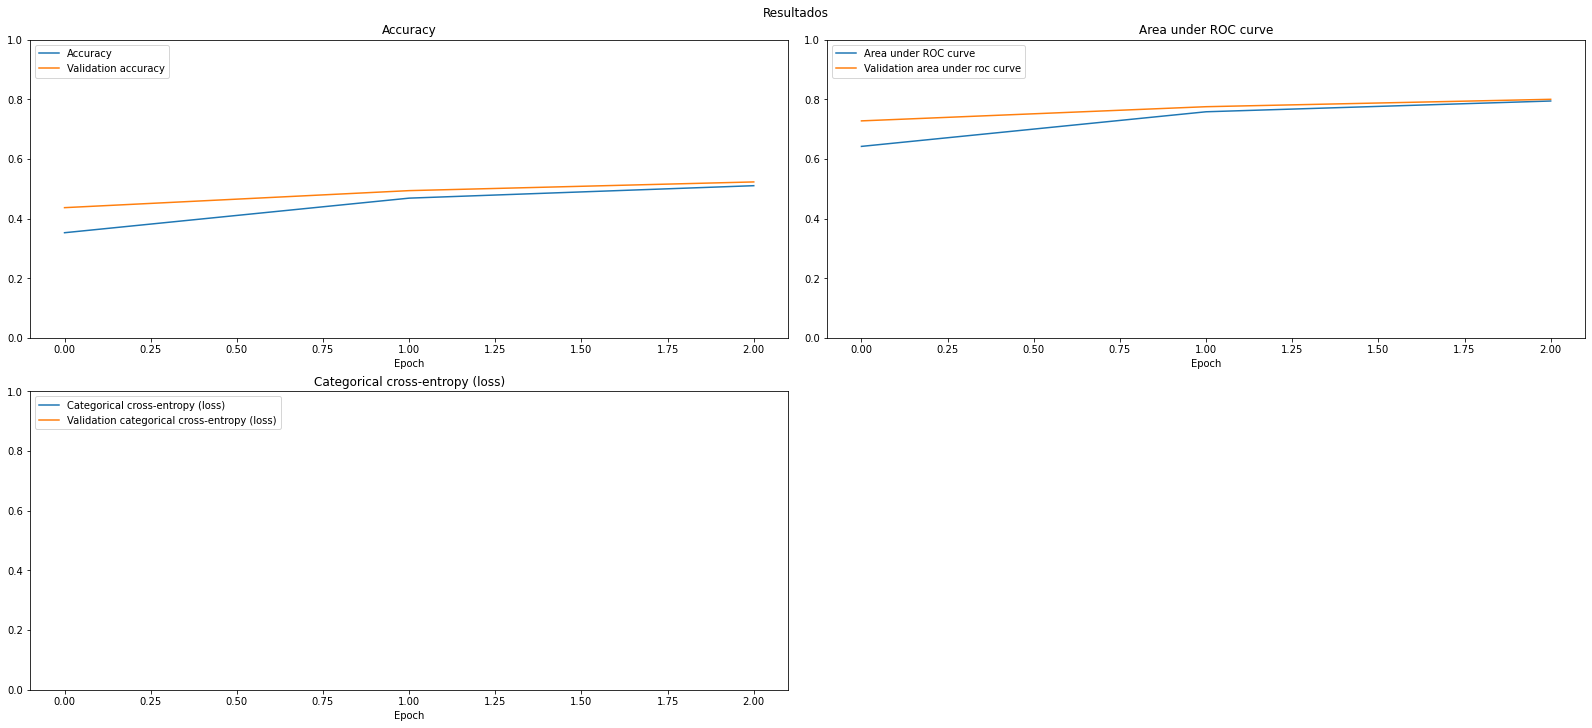

In [ ]:
nn = krm.Sequential()
exp = Experiment(e_id='0', model=nn, epochs=3, verbose=0)
exp.run()